**Provide a path to the url.mat file**

In [1]:
import scipy.io
data = scipy.io.loadmat('../../data/url.mat')
#'../../data/url.mat'
#'../../url.mat'

**Create a list for labels and data, where one entry is the data for the day with the corresponding index**

In [2]:
import numpy as np

num_of_days = 120
X, Y = [], []

for i in range(num_of_days):
    day_data = data["Day" + str(i)]
    X.append(day_data[0][0][0])
    Y.append(day_data[0][0][1])

# Data cleanup (remove list within list)
for i in range(len(Y)):
    Y[i] = Y[i].ravel()

**Function to do continous learning on a given classifier (clf) which must provide the partial_fit() function**

*A batch size can be set, in order to train on a batch of URLs instead of individual URLs (to achieve classic online-learning, just set batch_size to 1*

*Returns an array of cumulative error rates for each day*

In [3]:
def learn_incremental(clf, batch_size = 1000):
    
    error_rates = []
    num_of_days = 120
    err = 0
    
    for curr_day in range(num_of_days): # Looping through days
    
        if (curr_day != 45): # Day 45 has faulty data and is therefor excluded
            
            X_curr_day = X[curr_day]
            batches_amount = int(X_curr_day.shape[0] / batch_size)
            Y_curr_day = np.array_split(Y[curr_day], batches_amount)
    
            for j in range(batches_amount): # looping through individual url-batches
            
                # Split the data in slices of the batch_size
                select_ind = np.arange(j * batch_size, (j+1) * batch_size)
                X_curr_url_batch, Y_curr_url_batch = X_curr_day[select_ind,:], Y_curr_day[j] 
        
                if (j > 0):
                    Y_preds = clf.predict(X_curr_url_batch)
            
                    for k in range(batch_size): # Compare given results to collected results and collect number of errors accordingly
                        if(Y_preds[k] != Y_curr_url_batch[k]):
                            err = err + 1
        
                # Continous fitting of urls and label
                clf.partial_fit(X_curr_url_batch, Y_curr_url_batch, classes=list(range(2)))            
            print("Log: Day {}: {}".format(curr_day ,err / X_curr_day.shape[0]))
            error_rates.append(err / X_curr_day.shape[0])
            err = 0
    return error_rates

In [4]:
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix

# takes a range of days (start until to)
# fits the model with the data from the range until "to" itself
# for day "to" for each url_batch the data is refitted (prevoius days data from range + all batches up to current)
# and predicticed for the succesive batch of urls
# returns the cumulative error rate for day "to"
# batch_size determines the size of url_batches for which data is predicted and fitted on the "to" day
def train_and_evaluate_day(start, to, clf):
    
    if (to == 45):
        print("ERROR CALLED ON 45 WHICH CONTAINS FAULTY DATA")
        return
    
    prev_x = X[0][0,:] #random row for initialization purposes, spliced off later before training
    prev_y = []
    for prev_day in range(start, to):
        
        if (prev_day != 45): # leave out day 45
            prev_x = vstack((prev_x, X[prev_day])) # stack up all matrices to previous day
            prev_y = np.concatenate((prev_y, Y[prev_day])) # stack up all labels to previous day
        
    # immediately splice off the first initial url used to initiate the matrix outside of the loop
    url_indexes_without_initial = np.arange(1, prev_x.shape[0])
    prev_x = prev_x.tocsr()[url_indexes_without_initial,:]
    
    # change X to row format for faster slicing row-wise.
    curr_day_x = X[to].tocsr()
    curr_day_y = Y[to] # new
    
    clf.fit(prev_x, prev_y) #new
    
    Y_preds = clf.predict(curr_day_x)
    
    # Return cumulative error rate
    return 1 - accuracy_score(curr_day_y, Y_preds)

In [5]:
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix

# takes a range of days (start until to)
# fits the model with the data from the range until "to" itself
# for day "to" for each url_batch the data is refitted (prevoius days data from range + all batches up to current)
# and predicticed for the succesive batch of urls
# returns the cumulative error rate for day "to"
# batch_size determines the size of url_batches for which data is predicted and fitted on the "to" day
def train_and_evaluate(start, to, clf, batch_size = 1):
    
    if (to == 45):
        print("ERROR CALLED ON 45 WHICH CONTAINS FAULTY DATA")
        return
    
    prev_x = X[0][0,:] #random row for initialization purposes, spliced off later before classifying
    
    prev_y = []
    for prev_day in range(start, to):
        
        if (prev_day != 45): # leave out day 45
            prev_x = vstack((prev_x, X[prev_day])) # stack up all matrices to previous day
            prev_y = np.concatenate((prev_y, Y[prev_day])) # stack up all labels to previous day
        
    # immediately splice off the first initial url used to initiate the matrix outside of the loop
    url_indexes_without_initial = np.arange(1, prev_x.shape[0])
    prev_x = prev_x.tocsr()[url_indexes_without_initial,:]
    
    # change X to row format for faster slicing row-wise.
    curr_day_x = X[to].tocsr()
    
    # split the data in slices of batch_size
    batches_amount = int(curr_day_x.shape[0] / batch_size)
    curr_day_y = np.array_split(Y[to], batches_amount)
    
    err = 0
    x_batches = X[0][0,:] #random row for initialization purposes, spliced off later before classifying
    y_batches = []
    for j in range(batches_amount): # looping through individual url-batches
       
        # Combine previous days data and all batches up until current
        #print("parts:")
        #print("current batches: {}".format(x_batches.shape))
        #print("previous: {}".format(prev_x.shape))
        x_combined = vstack((prev_x, x_batches))
        #y_combined = prev_y.extend(y_batches.ravel())
        y_combined = np.append(prev_y, y_batches)
        #print("unsliced comb:  {}".format(x_combined.shape))
        
        if (j == 0):
            # immediately splice off the trailing url used to initiate the matrix outside of the loop
            url_indexes_without_trailing = np.arange(0, prev_x.shape[0])
            x_combined = x_combined.tocsr()[url_indexes_without_trailing,:]
            
            
        #print("sliced comb:  {}".format(x_combined.shape))
        #print("y-sliced comb:  {}".format(len(y_combined)))
        
        
        # Train for cumulated data excluding current batch
        if (x_combined.shape[0] != 0):
            clf.fit(x_combined, y_combined)
    
        # splice current batch off
        select_ind = np.arange(j * batch_size, (j+1) * batch_size)
        curr_x_batch, curr_y_batch = curr_day_x[select_ind,:], curr_day_y[j] 
        
        # Add current batch to cumulated list of batches
        x_batches = vstack((x_batches, curr_x_batch))
        if (j == 0):
            # immediately splice off the first initial url used to initiate the matrix outside of the loop
            url_indexes_without_initial = np.arange(1, x_batches.shape[0])
            x_batches = x_batches.tocsr()[url_indexes_without_initial,:]
            
        y_batches.extend(curr_y_batch)
        
        # Predict for current batch
        if (x_combined.shape[0] != 0):
            Y_preds = clf.predict(curr_x_batch)
           
            # Collect errors
            # todo replace with accuracy score
            for k in range(batch_size):
                if(Y_preds[k] != curr_y_batch[k]):
                    err = err + 1
        
    return err / curr_day_x.shape[0] # Return cumulative error rate

### Batch-size and other global variables and imports:

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
import numpy as np

batch_size = 5
train_set_size = 17 # Determines on data of how many days training is performed for SVM-multi and SVM-multi-once

# Initialize error rates of the different classifiers
error_rates_pa = None
error_rates_svm_once = None
error_rates_svm_daily = None
error_rates_svm_multi_once = None
error_rates_svm_multi = None

### SVM-once
**Evaluate for all days**

In [7]:
clf = LinearSVC(C=0.01)

error_rates_svm_once = []
#rate = train_and_evaluate(0, 0, clf, batch_size)
#print("Error-rate Day {}   : {}".format(0, rate))
#error_rates_svm_once.append(rate)
clf.fit(X[0], Y[0])
for i in range(1, num_of_days):
    Y_preds = clf.predict(X[i])
    rate = 1 - accuracy_score(Y[i], Y_preds)
    error_rates_svm_once.append(rate)
    print("Error-rate Day {}   : {}".format(i,rate))


Error-rate Day 1   : 0.02705000000000002
Error-rate Day 2   : 0.021950000000000025
Error-rate Day 3   : 0.02210000000000001
Error-rate Day 4   : 0.02475000000000005
Error-rate Day 5   : 0.027100000000000013
Error-rate Day 6   : 0.03015000000000001
Error-rate Day 7   : 0.03444999999999998
Error-rate Day 8   : 0.03344999999999998
Error-rate Day 9   : 0.03705000000000003
Error-rate Day 10   : 0.03385000000000005
Error-rate Day 11   : 0.03259999999999996
Error-rate Day 12   : 0.027599999999999958
Error-rate Day 13   : 0.022150000000000003
Error-rate Day 14   : 0.030100000000000016
Error-rate Day 15   : 0.02664999999999995
Error-rate Day 16   : 0.029299999999999993
Error-rate Day 17   : 0.025000000000000022
Error-rate Day 18   : 0.025000000000000022
Error-rate Day 19   : 0.024900000000000033
Error-rate Day 20   : 0.03180000000000005
Error-rate Day 21   : 0.03925000000000001
Error-rate Day 22   : 0.03854999999999997
Error-rate Day 23   : 0.03634999999999999
Error-rate Day 24   : 0.0376999999

### SVM-daily
**Train on data of previous day and predict of successive day**

In [8]:
clf = LinearSVC(C=0.01)

error_rates_svm_daily = []
#error_rates_svm_daily.append(train_and_evaluate(0, 0, clf, batch_size))
#print("Error-rate Day {}   : {}".format(0, error_rates_svm_daily[0]))
for i in range(0, num_of_days - 1):
    # i being the current day.
    clf.fit(X[i], Y[i])
    
    # i + 1 being the next day on which the model is being tested on. 
    Y_preds = clf.predict(X[i + 1])
    rate = 1 - accuracy_score(Y[i + 1], Y_preds)
    error_rates_svm_daily.append(rate)
    print("Error-rate Day {}   : {}".format(i + 1, rate))


Error-rate Day 1   : 0.02705000000000002
Error-rate Day 2   : 0.021299999999999986
Error-rate Day 3   : 0.02124999999999999
Error-rate Day 4   : 0.023950000000000027
Error-rate Day 5   : 0.023150000000000004
Error-rate Day 6   : 0.018299999999999983
Error-rate Day 7   : 0.02300000000000002
Error-rate Day 8   : 0.022150000000000003
Error-rate Day 9   : 0.027000000000000024
Error-rate Day 10   : 0.02429999999999999
Error-rate Day 11   : 0.023050000000000015
Error-rate Day 12   : 0.023399999999999976
Error-rate Day 13   : 0.01849999999999996
Error-rate Day 14   : 0.026100000000000012
Error-rate Day 15   : 0.020449999999999968
Error-rate Day 16   : 0.02100000000000002
Error-rate Day 17   : 0.020299999999999985
Error-rate Day 18   : 0.021399999999999975
Error-rate Day 19   : 0.020299999999999985
Error-rate Day 20   : 0.02300000000000002
Error-rate Day 21   : 0.029900000000000038
Error-rate Day 22   : 0.02100000000000002
Error-rate Day 23   : 0.02675000000000005
Error-rate Day 24   : 0.03154

### SVM-multi-once

**Train once on data for days 0-16 (train_set_size) and (evaluate for those days)**

In [9]:
clf = LinearSVC(C=0.01)

error_rates_svm_multi_once =  []

for i in range(1, train_set_size):
    rate = train_and_evaluate_day(0, i, clf)
    error_rates_svm_multi_once.append(rate)
    print("Error-rate Day {}   : {}".format(i, rate))

Error-rate Day 1   : 0.02705000000000002
Error-rate Day 2   : 0.019000000000000017
Error-rate Day 3   : 0.018000000000000016
Error-rate Day 4   : 0.019649999999999945
Error-rate Day 5   : 0.01990000000000003
Error-rate Day 6   : 0.01824999999999999
Error-rate Day 7   : 0.021499999999999964
Error-rate Day 8   : 0.01795000000000002
Error-rate Day 9   : 0.020950000000000024
Error-rate Day 10   : 0.018900000000000028
Error-rate Day 11   : 0.01739999999999997
Error-rate Day 12   : 0.016750000000000043
Error-rate Day 13   : 0.01319999999999999
Error-rate Day 14   : 0.018850000000000033
Error-rate Day 15   : 0.01419999999999999
Error-rate Day 16   : 0.013800000000000034


**Evaluate for the remaining days**

In [10]:
for i in range(train_set_size, num_of_days):
    Y_preds = clf.predict(X[i])
    rate = 1 - accuracy_score(Y[i], Y_preds)
    error_rates_svm_multi_once.append(rate)
    print("Error-rate Day {}   : {}".format(i,rate))  

Error-rate Day 17   : 0.014000000000000012
Error-rate Day 18   : 0.014650000000000052
Error-rate Day 19   : 0.013449999999999962
Error-rate Day 20   : 0.01429999999999998
Error-rate Day 21   : 0.018950000000000022
Error-rate Day 22   : 0.014149999999999996
Error-rate Day 23   : 0.018750000000000044
Error-rate Day 24   : 0.021399999999999975
Error-rate Day 25   : 0.02190000000000003
Error-rate Day 26   : 0.01685000000000003
Error-rate Day 27   : 0.01759999999999995
Error-rate Day 28   : 0.017549999999999955
Error-rate Day 29   : 0.020399999999999974
Error-rate Day 30   : 0.028349999999999986
Error-rate Day 31   : 0.027100000000000013
Error-rate Day 32   : 0.027599999999999958
Error-rate Day 33   : 0.024499999999999966
Error-rate Day 34   : 0.015599999999999947
Error-rate Day 35   : 0.02629999999999999
Error-rate Day 36   : 0.01475000000000004
Error-rate Day 37   : 0.014100000000000001
Error-rate Day 38   : 0.03159999999999996
Error-rate Day 39   : 0.03359999999999996
Error-rate Day 40  

### SVM-multi
**Train on data of previous 0-16 days (train_set_size) and predict of successive day**

In [11]:
clf = LinearSVC(C=0.01)

error_rates_svm_multi = []
for curr_day in range(1, num_of_days):
    
    if (curr_day != 45): # skip faulty data of day 45
        lower_bound = max(0, ((curr_day - 1) - train_set_size))
        upper_bound = curr_day
        rate = train_and_evaluate_day(lower_bound, curr_day, clf)
        error_rates_svm_multi.append(rate)
        print("Error-rate Day {}   : {}".format(curr_day, rate))


Error-rate Day 1   : 0.02705000000000002
Error-rate Day 2   : 0.019000000000000017
Error-rate Day 3   : 0.018000000000000016
Error-rate Day 4   : 0.019649999999999945
Error-rate Day 5   : 0.01990000000000003
Error-rate Day 6   : 0.01824999999999999
Error-rate Day 7   : 0.021499999999999964
Error-rate Day 8   : 0.01795000000000002
Error-rate Day 9   : 0.020950000000000024
Error-rate Day 10   : 0.018900000000000028
Error-rate Day 11   : 0.01739999999999997
Error-rate Day 12   : 0.016750000000000043
Error-rate Day 13   : 0.01319999999999999
Error-rate Day 14   : 0.018850000000000033
Error-rate Day 15   : 0.01419999999999999
Error-rate Day 16   : 0.013800000000000034
Error-rate Day 17   : 0.013850000000000029
Error-rate Day 18   : 0.014249999999999985
Error-rate Day 19   : 0.011700000000000044
Error-rate Day 20   : 0.013900000000000023
Error-rate Day 21   : 0.01715
Error-rate Day 22   : 0.0131
Error-rate Day 23   : 0.017650000000000055
Error-rate Day 24   : 0.01934999999999998
Error-rate D

### Passive Aggressive

In [12]:
clf = PassiveAggressiveClassifier(C=0.001, random_state = 123)

error_rates_pa = learn_incremental(clf, batch_size)

cnt = 0
for x in error_rates_pa:    
    print("Error-rate Day {}   : {}".format(cnt, x))
    cnt = cnt + 1

Log: Day 0: 0.0489375
Log: Day 1: 0.0313
Log: Day 2: 0.0239
Log: Day 3: 0.0229
Log: Day 4: 0.02655
Log: Day 5: 0.0255
Log: Day 6: 0.02245
Log: Day 7: 0.0259
Log: Day 8: 0.0235
Log: Day 9: 0.0286
Log: Day 10: 0.0251
Log: Day 11: 0.0225
Log: Day 12: 0.0236
Log: Day 13: 0.0188
Log: Day 14: 0.0235
Log: Day 15: 0.019
Log: Day 16: 0.0201
Log: Day 17: 0.0196
Log: Day 18: 0.0199
Log: Day 19: 0.01835
Log: Day 20: 0.02045
Log: Day 21: 0.0264
Log: Day 22: 0.0225
Log: Day 23: 0.02475
Log: Day 24: 0.0274
Log: Day 25: 0.02695
Log: Day 26: 0.0177
Log: Day 27: 0.0235
Log: Day 28: 0.02135
Log: Day 29: 0.02335
Log: Day 30: 0.03075
Log: Day 31: 0.02655
Log: Day 32: 0.0257
Log: Day 33: 0.0255
Log: Day 34: 0.00055
Log: Day 35: 0.03045
Log: Day 36: 0.00455
Log: Day 37: 0.001
Log: Day 38: 0.03575
Log: Day 39: 0.03505
Log: Day 40: 0.02445
Log: Day 41: 0.02035
Log: Day 42: 0.02695
Log: Day 43: 0.02285
Log: Day 44: 0.01535
Log: Day 46: 0.0205
Log: Day 47: 0.0193
Log: Day 48: 0.02345
Log: Day 49: 0.0261
Log: Day

**There are two cleanup functions provided which may be used to catch outliers in the results**

*For further information on their use in this case, please refer to the accompanying paper*

In [13]:
def cleanup(x, y):
    
    # Cleanup outliers in data
    outliers = []
    for i in range(len(y)):
        if (y[i] > 4.5 or y[i] < 0.5):
            outliers = np.append(outliers, i)
    
    offset = 0
    for outl in outliers:
        y = np.delete(y, int(outl) - offset)
        x = x[:-1]
        offset = offset + 1
        
    return x, y

In [14]:
def cleanup2(x, y, top, bot):
    
    # Cleanup outliers in data
    outliers = []
    for i in range(len(y)):
        if (y[i] > top or y[i] < bot):
            outliers = np.append(outliers, i)
    
    offset = 0
    for outl in outliers:
        y = np.delete(y, int(outl) - offset)
        x = x[:-1]
        offset = offset + 1
        
    return x, y

In [15]:
def _calc_line(x, y):
    
    # create polynomial equation and calculate line
    theta = np.polyfit(x, y, 8)
    return theta[8] + theta[7] * pow(x, 1) + theta[6] * pow(x, 2) + theta[5] * pow(x, 3) + theta[4] * pow(x, 4) + theta[3] * pow(x, 5) + theta[2] * pow(x, 6) + theta[1] * pow(x, 7) + theta[0] * pow(x, 8)

In [16]:
def _plot(y, color, marker, linestyle, scatter, label, doCleanup):
    
    # Set up the day_indexes with the missing 45th day in mind
    x = np.arange(1, 120) 
    
    # attend to data size imbalances (day 45 outages)
    if (y.shape[0] < x.shape[0]):
        x = x[:-1]
        
    y = y * 100
    
    if (doCleanup):
        x, y = cleanup(x, y)
    
        if (color == 'r'):
            x, y = cleanup2(x, y, 3, 1)
    
    if (scatter):
        plt.scatter(x, y, c=color)
    
    y = _calc_line(x, y)
    plt.plot(x, y, "{}{}{}".format(marker, color, linestyle), markevery=5, label=label)

In [21]:
def plot8degree(error_rates_pa, error_rates_svm_once, error_rates_svm_daily,
                error_rates_svm_multi_once, error_rates_svm_multi, batch_size, scatter = False, doCleanup = False):

    if (error_rates_pa is not None):
        _plot(np.array(error_rates_pa), 'r', 'v', '-', scatter, "PA", doCleanup)
        
    if (error_rates_svm_once is not None):
        _plot(np.array(error_rates_svm_once), 'k', 's', '-', scatter, "SVM-once", doCleanup)
        
    if (error_rates_svm_daily is not None):
        _plot(np.array(error_rates_svm_daily), 'm', '+', '--', scatter, "SVM-daily", doCleanup)
    
    if (error_rates_svm_multi_once is not None):
        _plot(np.array(error_rates_svm_multi_once), 'b', 'o', '--', scatter, "SVM-multi-once", doCleanup)

    if (error_rates_svm_multi is not None):
        _plot(np.array(error_rates_svm_multi), 'g', 'x', '-', scatter, "SVM-multi", doCleanup)
        
    title = 'Experiment 1 with batch size {}'.format(batch_size)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Cumulative error rate (%)')

    if (not scatter):
        plt.ylim([1,4])
        
    plt.xlim([0,100])
    plt.legend()
    plt.savefig("{}-scatter_{}-cleanup_{}.svg".format(title, scatter, doCleanup), format='svg', dpi=1200)

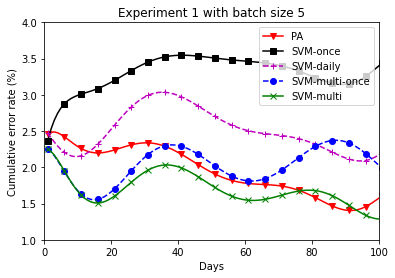

In [18]:
plot8degree(error_rates_pa, error_rates_svm_once, error_rates_svm_daily,
                error_rates_svm_multi_once, error_rates_svm_multi, batch_size, False, True)

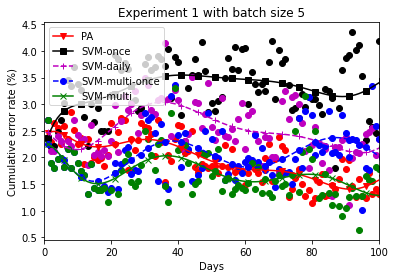

In [22]:
plot8degree(error_rates_pa, error_rates_svm_once, error_rates_svm_daily,
                error_rates_svm_multi_once, error_rates_svm_multi, batch_size, True, True)

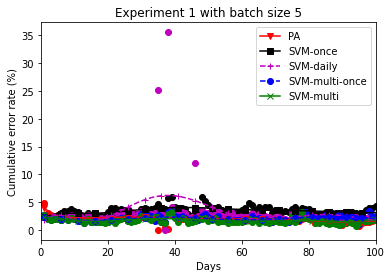

In [20]:
plot8degree(error_rates_pa, error_rates_svm_once, error_rates_svm_daily,
                error_rates_svm_multi_once, error_rates_svm_multi, batch_size, True, False)